In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [41]:
# Synthetic data generation:
np.random.seed(100)
n_samples = 10000

rng = np.random.default_rng()

time = (np.datetime64('2023-01-01') + np.arange(10000) * np.timedelta64(1, 'h')).astype("datetime64[ns]")
frac_yr = (time.astype('datetime64[D]').astype(int) % 366) / 366
frac_day = (time.astype('datetime64[h]').astype(int) % 24) / 24

df = pl.DataFrame({
    "time": time,
    "frac_yr": frac_yr,
    "frac_day": frac_day,
    "t2m_obs": 10 + np.random.rand(n_samples) * 4 + np.sin(2 * np.pi * (frac_yr - 0.15)) * 10 + np.sin(2 * np.pi * (frac_day - 0.15)) * 8,
    "t2m_gfs": 10 + np.random.rand(n_samples) * 5 + np.sin(2 * np.pi * (frac_yr - 0.14)) * 9 + np.sin(2 * np.pi * (frac_day - 0.16)) * 7.9,
    "t2m_ifs": 10 + np.random.rand(n_samples) * 7 + np.sin(2 * np.pi * (frac_yr - 0.16)) * 11 + np.sin(2 * np.pi * (frac_day - 0.15)) * 9.1,
    "t2m_aifs": 10 + np.random.rand(n_samples) * 5 + np.sin(2 * np.pi * (frac_yr - 0.15)) * 10 + np.sin(2 * np.pi * (frac_day - 0.14)) * 8.5,
})

df = df.with_columns([
    pl.col("t2m_obs").shift(1).alias("t2m_obs_lag1"),
])

df

time,frac_yr,frac_day,t2m_obs,t2m_gfs,t2m_ifs,t2m_aifs,t2m_obs_lag1
datetime[ns],f64,f64,f64,f64,f64,f64,f64
2023-01-01 00:00:00,0.89071,0.0,-4.281487,-1.329003,-2.197186,-2.978731,null
2023-01-01 01:00:00,0.89071,0.041667,-3.904056,0.622831,-1.332027,-4.211876,-4.281487
2023-01-01 02:00:00,0.89071,0.083333,-1.538793,2.034031,-1.426879,0.971398,-3.904056
2023-01-01 03:00:00,0.89071,0.125,2.144658,0.315933,-1.921903,1.930146,-1.538793
2023-01-01 04:00:00,0.89071,0.166667,0.872133,4.909144,6.60372,5.817034,2.144658
…,…,…,…,…,…,…,…
2024-02-21 11:00:00,0.027322,0.458333,12.939956,12.075992,16.257737,13.788009,13.479832
2024-02-21 12:00:00,0.027322,0.5,10.685034,14.72428,11.611482,13.163815,12.939956
2024-02-21 13:00:00,0.027322,0.541667,9.510376,13.354183,12.333849,11.021829,10.685034


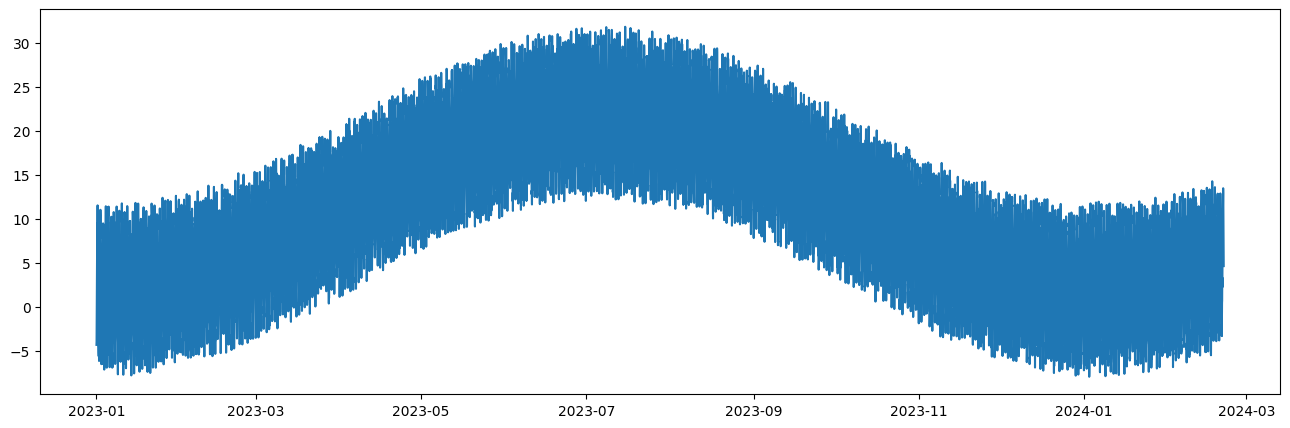

In [43]:
plt.figure(figsize=(16, 5))
plt.plot(df["time"], df['t2m_obs'])

# plt.xlim(np.datetime64('2023-03-01'), np.datetime64('2023-03-10'))

In [44]:
# Split into train and test DataFrames:
train = df[1:8000]
test = df[8000:]

train

time,frac_yr,frac_day,t2m_obs,t2m_gfs,t2m_ifs,t2m_aifs,t2m_obs_lag1
datetime[ns],f64,f64,f64,f64,f64,f64,f64
2023-01-01 01:00:00,0.89071,0.041667,-3.904056,0.622831,-1.332027,-4.211876,-4.281487
2023-01-01 02:00:00,0.89071,0.083333,-1.538793,2.034031,-1.426879,0.971398,-3.904056
2023-01-01 03:00:00,0.89071,0.125,2.144658,0.315933,-1.921903,1.930146,-1.538793
2023-01-01 04:00:00,0.89071,0.166667,0.872133,4.909144,6.60372,5.817034,2.144658
2023-01-01 05:00:00,0.89071,0.208333,3.37025,7.333426,4.167184,8.491886,0.872133
…,…,…,…,…,…,…,…
2023-11-30 03:00:00,0.800546,0.125,1.90526,2.505071,4.373378,3.384038,1.427746
2023-11-30 04:00:00,0.800546,0.166667,3.628012,6.401989,4.540498,6.536019,1.90526
2023-11-30 05:00:00,0.800546,0.208333,7.801796,5.942662,6.68273,10.104008,3.628012


In [45]:
# Define features & target DataFrames:
feature_cols = ["t2m_gfs", "t2m_ifs", "t2m_aifs", "t2m_obs_lag1"]

X_train = train.select(feature_cols)
y_train = train.select("t2m_obs")

X_test = test.select(feature_cols)
y_test = test.select("t2m_obs")

In [46]:
# Fit linear regression model:
mdl_lreg = LinearRegression().fit(X_train, y_train)

# Make predictions on test set:
y_pred = mdl_lreg.predict(X_test)

# Calculate mean squared error:
mse = mean_squared_error(y_test.to_numpy(), y_pred)

print(f"Linear Regression Coefficients: {mdl_lreg.coef_}")
print(f"Linear Regression Intercept: {mdl_lreg.intercept_}")
print(f"Mean Squared Error on Test Set: {mse}")
print(f"Root Mean Squared Error on Test Set: {np.sqrt(mse)}")

Linear Regression Coefficients: [[0.21375497 0.18132723 0.358001   0.22833402]]
Linear Regression Intercept: [-0.3126866]
Mean Squared Error on Test Set: 2.08948355232839
Root Mean Squared Error on Test Set: 1.4455046012823307


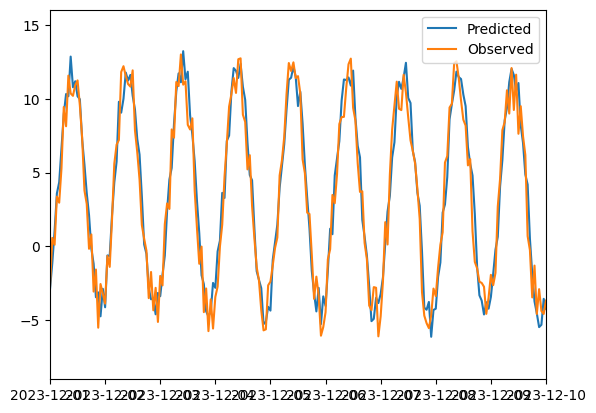

In [50]:
plt.figure()
plt.plot(test.select("time"), y_pred, label="Predicted")
plt.plot(test.select("time"), y_test, label="Observed")

plt.xlim(np.datetime64('2023-12-01'), np.datetime64('2023-12-10'))
plt.legend()